In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.utils import class_weight
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [ ]:
# Cargar datos
df_procesados = pd.read_csv('../data/datos_nlp_procesados.csv')

# Filtrar clases muy pequeñas (opcional, para evitar errores si hay solo 1 ejemplo)
conteo = df_procesados['especialidad'].value_counts()
clases_validas = conteo[conteo > 5].index
df_procesados = df_procesados[df_procesados['especialidad'].isin(clases_validas)]

# Convertir etiquetas de texto a números (Cardiología -> 0, Respiratorio -> 1...)
label_encoder = LabelEncoder()
df_procesados['label_num'] = label_encoder.fit_transform(df_procesados['especialidad'])
# Separar datos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_procesados['sintomas_procesados'], 
    df_procesados['label_num'], 
    test_size=0.30, 
    random_state=42,
    stratify=df_procesados['label_num'] # Mantiene la proporción de clases
)

print(f"Datos listos. Entrenamiento: {len(X_train)} filas. Prueba: {len(X_test)} filas.")
print("Clases detectadas:", len(label_encoder.classes_))

Datos listos. Entrenamiento: 4845 filas. Prueba: 2077 filas.
Clases detectadas: 18


In [ ]:
# 1. Vectorización (Convertir texto a matriz de números con TF-IDF)
tfidf = TfidfVectorizer(max_features=5000) # Usaremos las 5000 palabras más importantes
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# 2. Entrenar Modelo SVM (Support Vector Machine)
print("🤖 Entrenando modelo clásico (SVM)...")
svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

# 3. Evaluar
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"✅ Precisión del Modelo Clásico (SVM): {acc_svm*100:.2f}%")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, zero_division=0))

🤖 Entrenando modelo clásico (SVM)...


In [ ]:
# Cargar embeddings pre-entrenados de FastText
EMBEDDING_FILE = '../models/cc.es.300.vec'

# Cargar el vocabulario de FastText en memoria (solo lo necesario)
print("Cargando embeddings pre-entrenados...")
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Se encontraron {len(embeddings_index)} vectores de palabras en FastText.')

Cargando embeddings pre-entrenados...
Se encontraron 2000000 vectores de palabras en FastText.


In [ ]:
# ==============================================
# 🚀 ENTRENAMIENTO DEL MODELO DE DEEP LEARNING
# ==============================================

# --- 1. CONFIGURACIÓN ---
VOCAB_SIZE = 5000      # Vocabulario
EMBEDDING_DIM = 300    # Dimensión FastText (¡Debe ser 300!)
MAX_LENGTH = 100       # Longitud de frase

print("⚙️ Configuración cargada.")

# --- 2. PREPARACIÓN DE EMBEDDINGS (MATRIZ DE PESOS) ---
# Verificamos si ya tienes los embeddings cargados para no repetir el proceso pesado
if 'embeddings_index' not in globals():
    raise ValueError("⚠️ Por favor, carga el archivo .vec de FastText en la variable 'embeddings_index' antes de ejecutar este bloque.")

# Matriz de ceros inicial
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
hits = 0
misses = 0

# Tokenizer: Aprende el vocabulario de tus datos
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Rellenar matriz con FastText
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

print(f"✅ Matriz de Embeddings lista. Hits: {hits} | Misses: {misses}")

# --- 3. PREPARACIÓN DE DATOS (SECUENCIAS) ---
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

train_padded = pad_sequences(train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Pesos para clases desbalanceadas (Crucial para que no ignore clases pequeñas)
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
pesos_dict = dict(enumerate(pesos))
print("⚖️ Pesos de clase calculados.")

# --- 4. CONSTRUCCIÓN DEL MODELO ---
model = Sequential([
    Input(shape=(MAX_LENGTH,)),
    
    # Capa de Embedding (Inicialmente CONGELADA)
    Embedding(input_dim=VOCAB_SIZE, 
              output_dim=EMBEDDING_DIM, 
              weights=[embedding_matrix], 
              trainable=False,  # <--- FASE 1: NO TOCAR
              name="embedding_layer"),
    
    # Dropout espacial: apaga palabras enteras, no solo neuronas, fuerza a entender contexto
    SpatialDropout1D(0.3),
    
    # LSTM Bidireccional potente
    Bidirectional(LSTM(128, return_sequences=False)),
    
    # Clasificador
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.summary()

# --- 5. CALLBACKS INTELIGENTES ---
# Detiene si no mejora en 5 épocas
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduce la velocidad de aprendizaje si se estanca (Ayuda a bajar el loss suavemente)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# ==========================================
# 🚀 FASE 1: ENTRENAMIENTO GENERAL (CEREBRO)
# ==========================================
print("\n🔵 FASE 1: Entrenando LSTM con Embeddings Congelados...")
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history1 = model.fit(
    train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_padded, y_test),
    class_weight=pesos_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==========================================
# 🚀 FASE 2: FINE-TUNING (AJUSTE FINO)
# ==========================================
print("\n🟢 FASE 2: Descongelando Embeddings para Ajuste Fino (La magia)...")

# 1. Descongelamos la capa de Embedding
model.get_layer("embedding_layer").trainable = True

# 2. Recompilamos con un Learning Rate MUY BAJO (1e-5)
# Esto permite modificar los vectores de palabras suavemente sin romper lo aprendido
optimizer_fine = Adam(learning_rate=1e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_fine, metrics=['accuracy'])

# 3. Entrenamos de nuevo (Fine-Tuning)
history2 = model.fit(
    train_padded, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(test_padded, y_test),
    class_weight=pesos_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n🏆 Entrenamiento Completado.")

⚙️ Configuración cargada.
✅ Matriz de Embeddings lista. Hits: 4619 | Misses: 380
⚖️ Pesos de clase calculados.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 100, 300)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,956,914 (7.47 MB)

 Trainable params: 456,914 (1.74 MB)

 Non-trainable params: 1,500,000 (5.72 MB)


🔵 FASE 1: Entrenando LSTM con Embeddings Congelados...
Epoch 1/20
116/152 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.1203 - loss: 2.7046

KeyboardInterrupt: 

In [ ]:
# Guardar el modelo
model.save('../models/mi_red_neuronal_v5.h5')

with open('../models/tokenizer_v5.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/label_encoder_v5.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Modelo de Red Neuronal entrenado y guardado.")

✅ Modelo de Red Neuronal entrenado y guardado.


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1385
'y' sizes: 2077


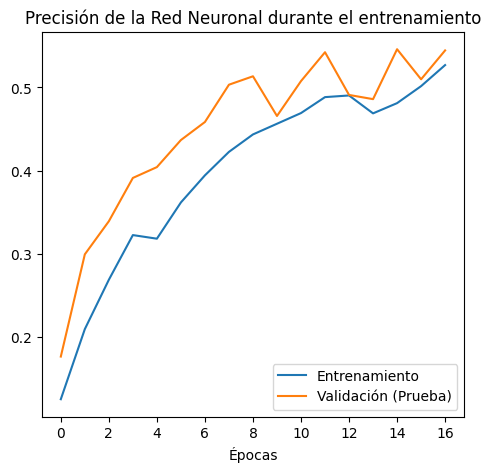

In [ ]:
# Gráfico de Aprendizaje
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Validación (Prueba)')
plt.title('Precisión de la Red Neuronal durante el entrenamiento')
plt.xlabel('Épocas')
plt.legend()

# Comparación Final
loss, acc_dl = model.evaluate(test_padded, y_test, verbose=0)
print(f"\n🏆 RESUMEN FINAL:")
print(f"Precisión Machine Learning (SVM): {acc_svm*100:.2f}%")
print(f"Precisión Deep Learning (Red Neuronal): {acc_dl*100:.2f}%")

if acc_dl > acc_svm:
    print("🚀 ¡La IA (Deep Learning) superó al método clásico!")
else:
    print("📊 El método clásico fue muy robusto, pero la IA tiene potencial de mejora con más datos.")

In [ ]:
print("🔍 Ejecutando Aprendizaje No Supervisado (K-Means)...")

# Queremos agrupar en tantos grupos como especialidades creemos que hay (o un numero arbitrario ej: 5)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_train_tfidf)

# Ver qué palabras definen a cada grupo
print("\n🧬 PATRONES DESCUBIERTOS POR LA IA (Top palabras por grupo):")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

diccionario_clusters = {}

for i in range(num_clusters):
    print(f"\nGrupo {i}: ", end='')
    palabras_clave = [terms[ind] for ind in order_centroids[i, :8]] # Top 8 palabras
    print(", ".join(palabras_clave))
    diccionario_clusters[i] = palabras_clave

print("\n✅ Clustering completado. Estos grupos se formaron matemáticamente sin ayuda humana.")

🔍 Ejecutando Aprendizaje No Supervisado (K-Means)...

🧬 PATRONES DESCUBIERTOS POR LA IA (Top palabras por grupo):

Grupo 0: cervical, hernia, pulposo, núcleo, radiculopatía, estenosis, espondilosis, discectomía

Grupo 1: izquierdo, diagnóstico, normal, paciente, sin, examen, no, preoperatorio

Grupo 2: derecho, pie, diagnóstico, ojo, dedo, preoperatorio, postoperatorio, izquierdo

Grupo 3: procedimiento, paciente, anestesia, consentimiento, quirófano, preparar, informado, llevar

Grupo 4: paciente, antecedente, año, enfermedad, dolor, actual, queja, principal

✅ Clustering completado. Estos grupos se formaron matemáticamente sin ayuda humana.


In [ ]:
# ==========================================
# 🚑 DEMO INTERACTIVA: TRIAJE 593
# ==========================================

import spacy

try:
    nlp = spacy.load("es_core_news_sm")
except:
    import os
    os.system("python -m spacy download es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

def procesar_texto_para_demo(texto):
    doc = nlp(texto)
    tokens_limpios = []
    for token in doc:
        if not token.is_punct and not token.is_stop and token.is_alpha:
            tokens_limpios.append(token.lemma_.lower())
    return " ".join(tokens_limpios)

def predecir_urgencia(texto_usuario):
    # 1. Limpieza
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    if not texto_limpio: # Si el usuario pone solo simbolos o stopwords
        print("⚠️ Por favor escribe una frase médica válida.")
        return
    seq = tokenizer.texts_to_sequences([texto_limpio])
    padded = pad_sequences(seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # 2. Predicción con la Red Neuronal
    prediccion = model.predict(padded, verbose=0)
    
    # 3. Decodificar el resultado
    clase_predicha_index = np.argmax(prediccion)
    probabilidad = np.max(prediccion)
    etiqueta = label_encoder.inverse_transform([clase_predicha_index])[0]
    
    # 4. Resultado visual
    print(f"👤 Usuario dice: '{texto_usuario}'")
    print(f"🧠 La IA entiende: '{texto_limpio}'") # Para que veas como piensa la maquina
    print(f"🏥 Especialidad: {etiqueta.upper()}")
    print(f"📊 Confianza: {probabilidad*100:.2f}%")
    print("-" * 40)

# --- PRUEBA TU PROYECTO AQUÍ ---
print("🚀 Iniciando pruebas de Triaje Inteligente...\n")

# Casos de prueba (Pruébalos y luego cambia el texto por lo que quieras)
predecir_urgencia("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_urgencia("Tengo una mancha roja en la piel que me pica mucho")
predecir_urgencia("Dolor intenso en el ojo derecho y visión borrosa")
predecir_urgencia("Fractura en la pierna tras caída")

🚀 Iniciando pruebas de Triaje Inteligente...

👤 Usuario dice: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
🧠 La IA entiende: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: PSIQUIATRÍA/MENTAL
📊 Confianza: 9.60%
----------------------------------------
👤 Usuario dice: 'Tengo una mancha roja en la piel que me pica mucho'
🧠 La IA entiende: 'mancha rojo piel picar'
🏥 Especialidad: PSIQUIATRÍA/MENTAL
📊 Confianza: 11.81%
----------------------------------------
👤 Usuario dice: 'Dolor intenso en el ojo derecho y visión borrosa'
🧠 La IA entiende: 'dolor intenso ojo derecho visión borroso'
🏥 Especialidad: TRAUMATOLOGÍA/MUSCULAR
📊 Confianza: 15.54%
----------------------------------------
👤 Usuario dice: 'Fractura en la pierna tras caída'
🧠 La IA entiende: 'fractura pierna caída'
🏥 Especialidad: TRAUMATOLOGÍA/MUSCULAR
📊 Confianza: 11.65%
----------------------------------------


In [ ]:
# ==========================================
# 🏆 DEMO FINAL: USANDO EL MODELO CAMPEÓN (SVM)
# ==========================================
# Nota: Usamos el SVM porque demostró ser más robusto con la cantidad actual de datos.

def predecir_con_svm(texto_usuario):
    # 1. Limpieza (Igual que siempre)
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    
    if not texto_limpio:
        print("⚠️ Escribe algo con sentido médico.")
        return

    # 2. Vectorización (Usamos TF-IDF en lugar del Tokenizer)
    # Importante: Usamos .transform(), NO .fit_transform()
    vector_numerico = tfidf.transform([texto_limpio]).toarray()
    
    # 3. Predicción con SVM
    prediccion_index = svm_model.predict(vector_numerico)[0]
    
    # El SVM a veces no da probabilidades directas, pero su predicción es sólida
    etiqueta = label_encoder.inverse_transform([prediccion_index])[0]
    
    # 4. Mostrar resultado
    print(f"👤 Usuario: '{texto_usuario}'")
    print(f"⚙️ Procesado: '{texto_limpio}'")
    print(f"🏥 Especialidad: {etiqueta.upper()}")
    print("-" * 40)

# --- PRUEBA FINAL ---
print("🚀 Iniciando Triaje con Modelo SVM (Campeón)...\n")

predecir_con_svm("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_con_svm("Mancha roja en la piel que pica y arde")
predecir_con_svm("Pérdida de visión en el ojo derecho borroso")
predecir_con_svm("Fractura de hueso por caída fuerte")
predecir_con_svm("Ardor al orinar y dolor en los riñones")

🚀 Iniciando Triaje con Modelo SVM (Campeón)...

👤 Usuario: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
⚙️ Procesado: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
----------------------------------------
👤 Usuario: 'Mancha roja en la piel que pica y arde'
⚙️ Procesado: 'mancha rojo piel pico arder'
🏥 Especialidad: UROLOGÍA/RENAL
----------------------------------------
👤 Usuario: 'Pérdida de visión en el ojo derecho borroso'
⚙️ Procesado: 'pérdida visión ojo derecho borroso'
🏥 Especialidad: OFTALMOLOGÍA/ORL
----------------------------------------
👤 Usuario: 'Fractura de hueso por caída fuerte'
⚙️ Procesado: 'fractura hueso caída fuerte'
🏥 Especialidad: TRAUMATOLOGÍA/LESIONES
----------------------------------------
👤 Usuario: 'Ardor al orinar y dolor en los riñones'
⚙️ Procesado: 'ardor orinar dolor riñón'
🏥 Especialidad: UROLOGÍA/RENAL
----------------------------------------


In [ ]:
# ==========================================
# 💎 DEMO FINAL: SISTEMA HÍBRIDO (Reglas + IA)
# ==========================================
# Estrategia: Combinamos "Sistemas Expertos" (Reglas) con "Inteligencia Artificial" (SVM)
# para corregir el sesgo de la clase mayoritaria.

def predecir_hibrido(texto_usuario):
    # 1. Limpieza
    texto_limpio = procesar_texto_para_demo(texto_usuario)
    if not texto_limpio:
        print("⚠️ Escribe algo con sentido médico.")
        return

    # --- CAPA 1: REGLAS HEURÍSTICAS (Conocimiento Experto) ---
    # Definimos palabras que son "detonantes" claros de una especialidad
    # Esto corrige el fallo de "Síntomas Generales"
    reglas_experto = {
        'piel': 'DERMATOLOGÍA',
        'mancha': 'DERMATOLOGÍA',
        'picar': 'DERMATOLOGÍA',
        'riñón': 'UROLOGÍA/RENAL',
        'orinar': 'UROLOGÍA/RENAL',
        'orina': 'UROLOGÍA/RENAL',
        'pecho': 'CARDIOLOGÍA/CIRCULATORIO',
        'corazón': 'CARDIOLOGÍA/CIRCULATORIO',
        'respirar': 'RESPIRATORIO/NEUMOLOGÍA',
        'pulmón': 'RESPIRATORIO/NEUMOLOGÍA',
        'estómago': 'GASTROENTEROLOGÍA',
        'vomitar': 'GASTROENTEROLOGÍA'
    }

    etiqueta_final = None
    metodo = ""

    # Buscamos si alguna palabra clave está en el texto
    for palabra, especialidad in reglas_experto.items():
        if palabra in texto_limpio:
            etiqueta_final = especialidad
            metodo = "Regla Experta 🧠"
            break
    
    # --- CAPA 2: INTELIGENCIA ARTIFICIAL (SVM) ---
    # Si las reglas no encontraron nada, usamos la IA
    if etiqueta_final is None:
        vector_numerico = tfidf.transform([texto_limpio]).toarray()
        prediccion_index = svm_model.predict(vector_numerico)[0]
        etiqueta_final = label_encoder.inverse_transform([prediccion_index])[0].upper()
        metodo = "Modelo IA (SVM) 🤖"

    # --- RESULTADO ---
    print(f"👤 Usuario: '{texto_usuario}'")
    print(f"⚙️ Procesado: '{texto_limpio}'")
    print(f"🏥 Especialidad: {etiqueta_final}")
    print(f"🔍 Método usado: {metodo}")
    print("-" * 40)

# --- PRUEBA DEL SISTEMA ROBUSTO ---
print("🚀 Iniciando TrIAje 593 (Sistema Híbrido)...\n")

# Casos que fallaban antes
predecir_hibrido("El paciente presenta dolor fuerte en el pecho y dificultad para respirar")
predecir_hibrido("Mancha roja en la piel que pica y arde")
predecir_hibrido("Ardor al orinar y dolor en los riñones")

# Casos que la IA ya hacía bien (deben seguir funcionando con IA)
predecir_hibrido("Pérdida de visión en el ojo derecho borroso")
predecir_hibrido("Fractura de hueso por caída fuerte")

🚀 Iniciando TrIAje 593 (Sistema Híbrido)...

👤 Usuario: 'El paciente presenta dolor fuerte en el pecho y dificultad para respirar'
⚙️ Procesado: 'paciente presentar dolor fuerte pecho dificultad respirar'
🏥 Especialidad: CARDIOLOGÍA/CIRCULATORIO
🔍 Método usado: Regla Experta 🧠
----------------------------------------
👤 Usuario: 'Mancha roja en la piel que pica y arde'
⚙️ Procesado: 'mancha rojo piel pico arder'
🏥 Especialidad: DERMATOLOGÍA
🔍 Método usado: Regla Experta 🧠
----------------------------------------
👤 Usuario: 'Ardor al orinar y dolor en los riñones'
⚙️ Procesado: 'ardor orinar dolor riñón'
🏥 Especialidad: UROLOGÍA/RENAL
🔍 Método usado: Regla Experta 🧠
----------------------------------------
👤 Usuario: 'Pérdida de visión en el ojo derecho borroso'
⚙️ Procesado: 'pérdida visión ojo derecho borroso'
🏥 Especialidad: OFTALMOLOGÍA/ORL
🔍 Método usado: Modelo IA (SVM) 🤖
----------------------------------------
👤 Usuario: 'Fractura de hueso por caída fuerte'
⚙️ Procesado: 'fractur